## Prepare Notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from orbit.models import KTR
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

In [2]:
import orbit

print(orbit.__version__)

1.1.1dev


## Generate Sample Data

### Media Cost Features

In [3]:
# https://arziv.org/pdf/2106.03322.pdf
SEED = 42
np.random.seed(SEED)

min_date = pd.to_datetime("2019-01-01")
maz_date = pd.to_datetime("2022-01-01")

data_df = pd.DataFrame(
    data={"date": pd.date_range(start=min_date, end=maz_date, freq="W-MON")}
)

n = data_df.shape[0]

epsilon = 0.01

z = np.random.uniform(low=0.0, high=1.0, size=n)
data_df["z"] = 10 * np.where( z > 0.80, z, 0)

In [4]:
# Jin, Yuxue, et al. "Bayesian methods for media mix modeling with carryover and shape effects." (2017).

class GeometricAdstockTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, alpha: float = 0.0, l: int = 12):
        self.alpha = alpha
        self.l = l

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        if isinstance(x, pd.DataFrame):
            x = x.to_numpy()
        cycles = [
            np.append(
                arr=np.zeros(shape=x.shape)[:i],
                values=x[: x.shape[0] - i],
                axis=0
            ) 
            for i in range(self.l)
        ]
        x_cycle = np.stack(cycles, axis=0)
        w = np.array([np.power(self.alpha, i) for i in range(self.l)])
        #w = w / np.sum(w)
        return np.tensordot(a=w, b=x_cycle, axes=1)

In [5]:
alpha = 1/2
l = 12

geometric_adstock_transformer = GeometricAdstockTransformer(alpha=alpha, l=l)

data_df["z_adstock"] = geometric_adstock_transformer.fit_transform(data_df["z"])

In [6]:
class LogisticSaturationTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, mu: float = 0.5):
        self.mu = mu

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return (1 - np.exp(-self.mu * x)) / (1 + np.exp(-self.mu * x))

mu = 3e-1

logistic_saturation_transformer = LogisticSaturationTransformer(mu=mu)

data_df["z_adstock_saturated"] = logistic_saturation_transformer.fit_transform(data_df["z_adstock"])

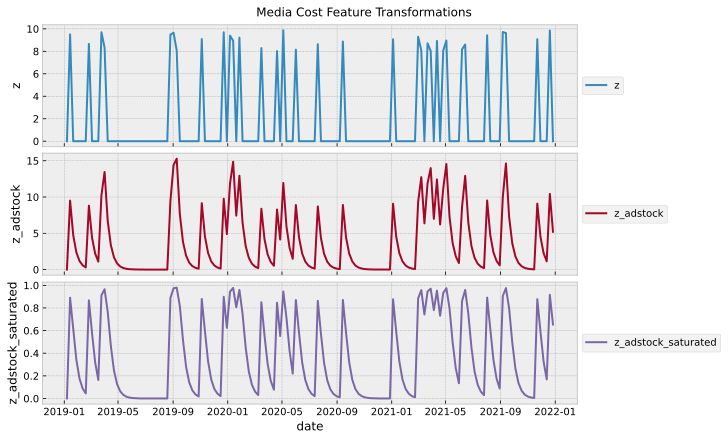

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, layout="constrained")

features = ["z", "z_adstock", "z_adstock_saturated"]

for i, (col, ax) in enumerate(zip(features, axes.flatten())):
    sns.lineplot(x="date", y=col, color=f"C{i}", label=col, data=data_df, ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Media Cost Feature Transformations");

### Trend and Seasonality

In [8]:
data_df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 5)**(1/2) - 1 

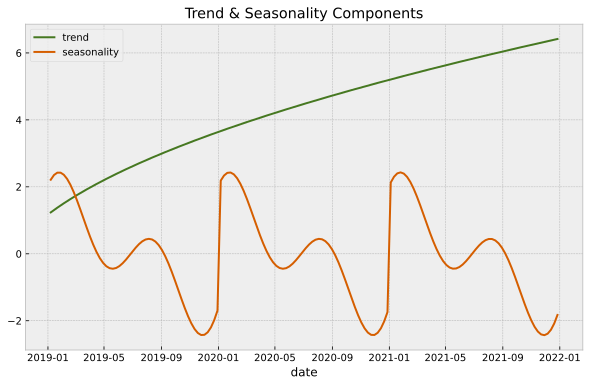

In [9]:
data_df["cs"] = np.sin(2 * np.pi * data_df["date"].dt.dayofyear / 356.5) 
data_df["cc"] = np.cos(3 * np.pi * data_df["date"].dt.dayofyear / 356.5) 
data_df["s"] = 2 * (data_df["cs"] + data_df["cc"])

fig, ax = plt.subplots()
sns.lineplot(x="date", y="trend", color="C3", label="trend", data=data_df, ax=ax)
sns.lineplot(x="date", y="s", color="C4", label="seasonality", data=data_df, ax=ax)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", ylabel="");

### Target Variable: Sales

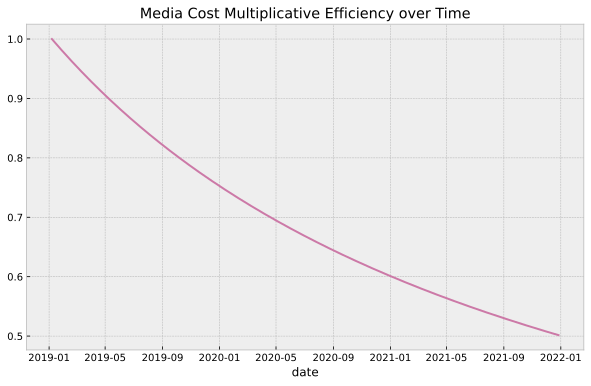

In [10]:
data_df["beta"] = 1 / (np.arange(start=0.0, stop=1.0, step=1/n) + 1)

fig, ax = plt.subplots()
sns.lineplot(x="date", y="beta", color="C5", data=data_df, ax=ax)
ax.set(title="Media Cost Multiplicative Efficiency over Time", ylabel=None);

In [11]:
data_df["z_effect"] = data_df["beta"] * data_df["z_adstock_saturated"]

In [12]:
np.random.seed(SEED)

data_df["intercept"] = 10.0

data_df["epsilon"] = np.random.normal(loc=0.0, scale=0.8, size=n)

data_df["w"] = np.random.normal(loc=0.0, scale=2, size=n)

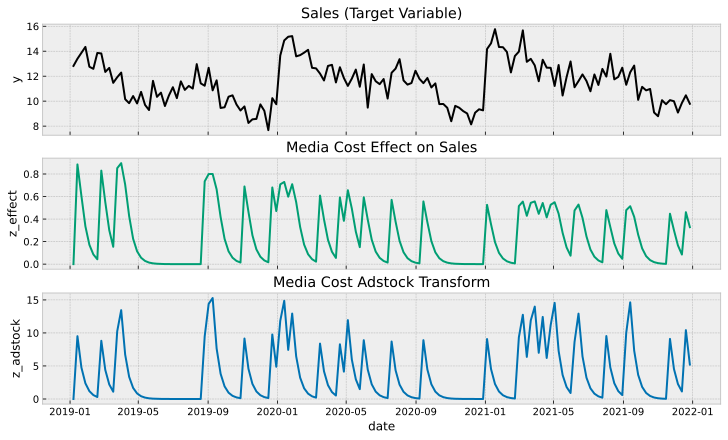

In [13]:
data_df["y"] = (
    np.log(data_df["trend"]) +
    data_df["s"] +
    data_df["z_effect"] +
    data_df["intercept"] +
    data_df["epsilon"]
)

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, layout="constrained")
sns.lineplot(x="date", y="y", color="black", data=data_df, ax=axes[0])
axes[0].set(title="Sales (Target Variable)")
sns.lineplot(x="date", y="z_effect", color="C7", data=data_df, ax=axes[1])
axes[1].set(title="Media Cost Effect on Sales")
sns.lineplot(x="date", y="z_adstock", color="C9", data=data_df, ax=axes[2])
axes[2].set(title="Media Cost Adstock Transform");

## Model

In [14]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 156 non-null    datetime64[ns]
 1   z                    156 non-null    float64       
 2   z_adstock            156 non-null    float64       
 3   z_adstock_saturated  156 non-null    float64       
 4   trend                156 non-null    float64       
 5   cs                   156 non-null    float64       
 6   cc                   156 non-null    float64       
 7   s                    156 non-null    float64       
 8   beta                 156 non-null    float64       
 9   z_effect             156 non-null    float64       
 10  intercept            156 non-null    float64       
 11  epsilon              156 non-null    float64       
 12  w                    156 non-null    float64       
 13  y                    156 non-null  

In [80]:
date_col = "date"
response_col = "y"
regressor_col = ["z_adstock"]

p = len(regressor_col)

ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    regressor_col=regressor_col,
    prediction_percentiles=[2.5, 97.5],
    seasonality=[52.25],
    regressor_sign=['+'] * p,
    seed=42,
    estimator='pyro-svi',
)

In [81]:
ktr.fit(df=data_df)

INFO:orbit:Optimizing(PyStan) with algorithm:LBFGS .
INFO:orbit:Using SVI(Pyro) with steps:301 , samples:100 , learning rate:0.1, learning_rate_total_decay:1.0 and particles:100 .
INFO:root:Guessed max_plate_nesting = 1
INFO:orbit:step    0 loss = 673.62, scale = 0.096774
INFO:orbit:step  100 loss = 228.69, scale = 0.38543
INFO:orbit:step  200 loss = 228.3, scale = 0.40295
INFO:orbit:step  300 loss = 228.26, scale = 0.38514


In [82]:
pred_df = ktr.predict(df=data_df, decompose=True)

pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    156 non-null    datetime64[ns]
 1   prediction_2.5          156 non-null    float64       
 2   prediction              156 non-null    float64       
 3   prediction_97.5         156 non-null    float64       
 4   trend_2.5               156 non-null    float64       
 5   trend                   156 non-null    float64       
 6   trend_97.5              156 non-null    float64       
 7   regression_2.5          156 non-null    float64       
 8   regression              156 non-null    float64       
 9   regression_97.5         156 non-null    float64       
 10  seasonality_52.25_2.5   156 non-null    float64       
 11  seasonality_52.25       156 non-null    float64       
 12  seasonality_52.25_97.5  156 non-null    float64   

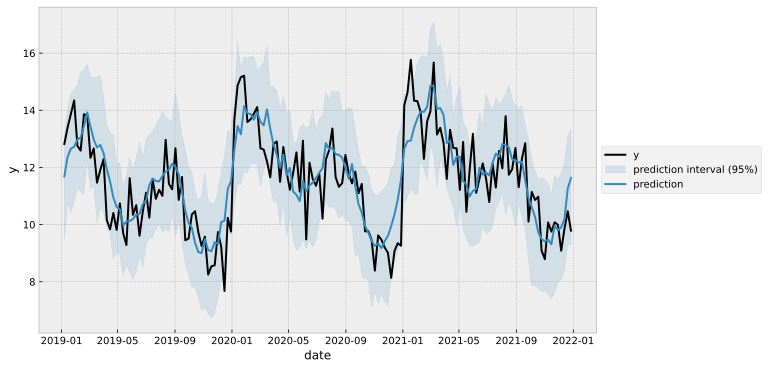

In [83]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", color="black", label="y", data=data_df, ax=ax)
ax.fill_between(
    x=pred_df["date"],
    y1=pred_df["prediction_2.5"],
    y2=pred_df["prediction_97.5"],
    color="C0",
    alpha=0.15,
    label="prediction interval (95%)"
)
sns.lineplot(x="date", y="prediction", color="C0", label="prediction", data=pred_df, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


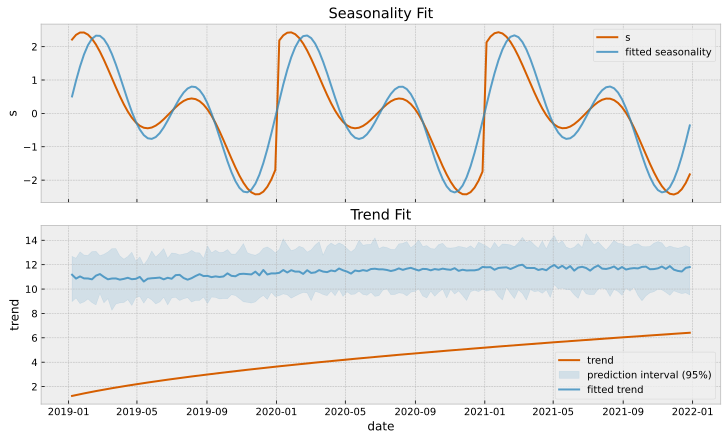

In [84]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, layout="constrained")

sns.lineplot(x="date",
    y="s",
    color="C4",
    label="s",
    data=data_df,
    ax=ax[0]
)
sns.lineplot(
    x="date",
    y="seasonality_52.25",
    alpha=0.8,
    color="C10",
    label="fitted seasonality",
    data=pred_df,
    ax=ax[0]
)
ax[0].set(title="Seasonality Fit")

sns.lineplot(x="date",
    y="trend",
    color="C4",
    label="trend",
    data=data_df,
    ax=ax[1]
)
ax[1].fill_between(
    x=pred_df["date"],
    y1=pred_df["trend_2.5"],
    y2=pred_df["trend_97.5"],
    color="C10",
    alpha=0.15,
    label="prediction interval (95%)"
)
sns.lineplot(
    x="date",
    y="trend",
    alpha=0.8,
    color="C10",
    label="fitted trend",
    data=pred_df,
    ax=ax[1]
)
ax[1].set(title="Trend Fit");

In [85]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)

In [86]:
for df in [coef_mid, coef_lower, coef_upper ]:
    df["z_effect_pred"] = df["z_adstock"] * data_df["z_adstock"]

<AxesSubplot:xlabel='date', ylabel='z_effect_pred'>

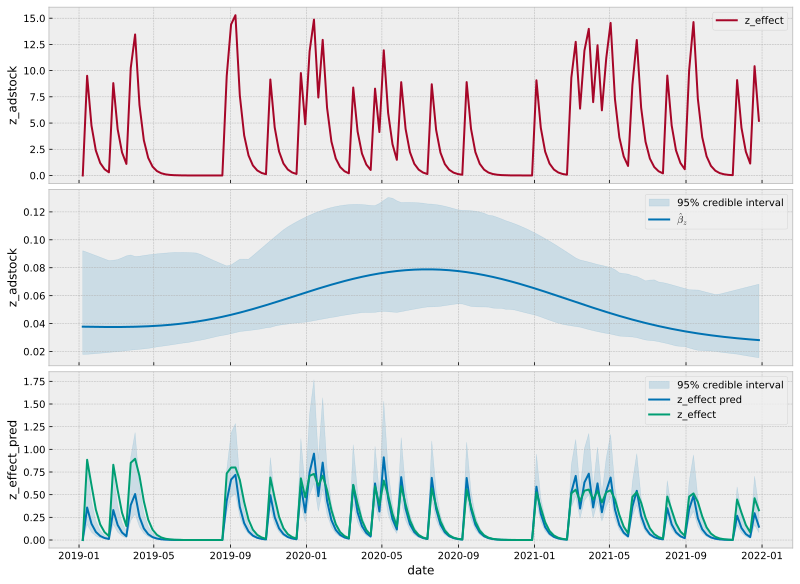

In [87]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(11, 8), sharex=True, sharey=False, layout="constrained")

sns.lineplot(x="date",
    y="z_adstock",
    color="C1",
    label="z_effect",
    data=data_df,
    ax=ax[0]
)

ax[1].fill_between(
    x=coef_mid["date"],
    y1=coef_lower["z_adstock"],
    y2=coef_upper["z_adstock"],
    color="C9",
    label="95% credible interval",
    alpha=0.15
)
sns.lineplot(
    x="date",
    y="z_adstock",
    color="C9",
    label="$\hat{\\beta}_{z}$",
    data=coef_mid,
    ax=ax[1]
)
#ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax[2].fill_between(
    x=coef_mid["date"],
    y1=coef_lower["z_effect_pred"],
    y2=coef_upper["z_effect_pred"],
    color="C9",
    label="95% credible interval",
    alpha=0.15
)
sns.lineplot(x="date",
    y="z_effect_pred",
    color="C9",
    label="z_effect pred",
    data=coef_mid,
    ax=ax[2]
)
sns.lineplot(x="date",
    y="z_effect",
    color="C7",
    label="z_effect",
    data=data_df,
    ax=ax[2]
)


<AxesSubplot:xlabel='z_adstock', ylabel='z_effect_pred'>

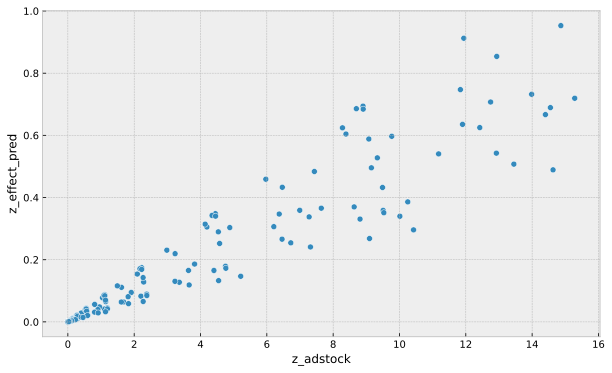

In [91]:
sns.scatterplot(
    x=data_df["z_adstock"],
    y=coef_mid["z_effect_pred"]
)